# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 3: Web APIs & NLP


--- 

*Group 3* | *Team Members: Constance, Wenzhe, Matthew, Joel*

### <b> Notebook 2: Filtering Top 4 and Bottom 4 Comments (By Comment Score) Across All Threads </b>

<b>(a) Overview of "Full" Datasets Available Following Scraping & Cleaning (As Documented under Notebook 1) </b>

The scraping and cleaning of 1,000 "hottest threads" and their accompanying comments across the "r/tea" and "r/coffee" subreddits leaves us with the following two datasets: 

|Dataset|"r/coffee" comments and accompanying thread info|
|---|---|
|Filename|coffee_comments_clean_merged.csv|
|No. of comments|31,227|
|No. of threads|633|
|Average no. of comments per thread|49.33|

<br>

|Dataset|"r/tea" comments and accompanying thread info|
|---|---|
|Filename|tea_comments_clean_merged.csv|
|No. of comments|12,201|
|No. of threads|878|
|Average no. of comments per thread|13.9|

<br>

<b>(b) Potential Drawbacks of Running Analyses on "Full" Datasets </b>

As the statistics above indicate, running analyses on the full range of comments to:<br>
(a) understand the general sentiments of coffee/tea drinkers, and <br>
(b) build a tea/coffee drinker classification model can be:

* computationally expensive, while
* leaving us with comments that both communities may not identify strongly with (given variation in the comments' number of up/down votes), thus hindering our analyses 

<br>
<b>(c) Filtering a Subset of Comments - Top 4 and Bottom 4 Comments (By Comment Score) Across All Threads</b>

Background: Comment Scores
* Each thread is given a comment score by the subreddit community
* The higher the comment score: the more users in the respective subreddit identifies with it
* The lower the comment score: the less users identify with that comment

Intuition for retaining top 4 and bottom 4 comments across all threads:
* A thread's top and bottom comments (based on number of up/down votes) reflect the strongest sentiments (e.g., approval/disapproval) by coffee/tea drinkers. 
* Filtering of these comments allows us to capture a range of (positive/negative) sentiments that the respective communities identify with most strongly, hence: 
    * aiding with sentiment analysis
    * aiding with classification of coffee and tea drinkers 
* Filtering across all threads also allows us to:
    * cover all discussion topics available in the data
* With a filtered dataset:
    * computational load of running analyses can be reduced

<br>
<b>(d) Structure of Notebook 2</b>

* Part 1: EDA to Illustrate Decision Making Approach towards Establishing Filtering Criteria
* Part 2: Filtering Code Implementation
* Part 3. Save Cleaned-Filtered Dataframes as CSV Files 


---

### Import Libraries & Read Cleaned Data

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read cleaned coffee and tea datasets
df_coffee = pd.read_csv("data/coffee_comments_clean_merged.csv")
df_tea    = pd.read_csv("data/tea_comments_clean_merged.csv")

---

### Part 1: EDA to Illustrate Decision Making Approach towards Establishing Filtering Criteria

<b> (a) Examine Proportion of Comments from Coffee & Tea Subreddits </b>

<function matplotlib.pyplot.show(close=None, block=None)>

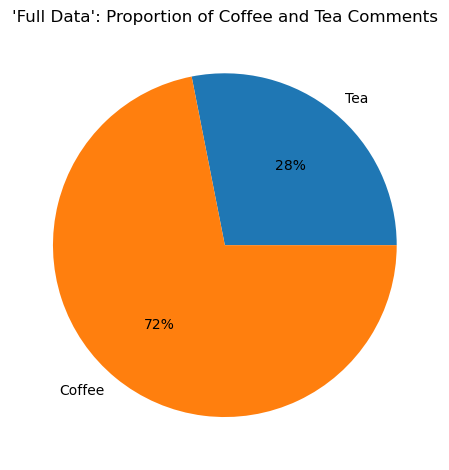

In [3]:
# plot out the proportion of comments from both subreddit
data = [df_tea.shape[0], df_coffee.shape[0]]
key = ["Tea", "Coffee"]

plt.pie(data, labels = key, autopct='%.0f%%')
plt.title("'Full Data': Proportion of Coffee and Tea Comments")
plt.tight_layout()
plt.show

Summary of Observations
* Currently we have ~12,000 comments from "r/tea" and ~31,000 comments from "r/Coffee" (from our info tables) and the proportion is shown in the piechart above
* As the number of comments from both subreddits is unbalanced, we will have to balance them out for building a "coffee/tea" drinker classification model

Approach: Next Steps
* After discussion, we felt that we do have quite a large amount of data from each subreddit and if we were to use all of it, computationally it would be quite extensive
* Hence, we could afford to reduce the data to a more manageable sample size
* Before we decide on what is the appropriate size, we decide to take a look at the number of threads we have and the average comments per thread

<b> (b) Examine No. of Threads and Average Comments per Thread in Each Dataset </b> 

In [4]:
# obtain thread/comments stats

df_dict = {"Dataset: coffee":df_coffee,
           "Dataset: tea":df_tea}

for desc, df in df_dict.items():

    print(desc)
    
    # 1. No. of comments
    print("No. of comments:", round(df.shape[0],2))

    # 2. No. of threads
    print("No. of threads:", df["thread_id"].nunique())

    # 3. Ave. no. of comments per thread
    print("Average no. of comments per thread:", round(df.groupby(by="thread_id")["comment_id"].count().mean(),2))
    print("")

Dataset: coffee
No. of comments: 31227
No. of threads: 633
Average no. of comments per thread: 49.33

Dataset: tea
No. of comments: 12201
No. of threads: 878
Average no. of comments per thread: 13.9



Summary of Observations
* Average no. of comments per thread is significantly lower in the tea dataset (~14/thread), compared that in the coffee dataset (~49/thread)

Approach: Next Steps
* Given the above, number of comments per thread to filter will need to be <14 - to minimise instances of all comments belong to a thread being filtered
* We thus decided to filter the "top 4 and bottom 4 comments by comment score" across all threads, with the view towards having a sizeable number of comments to analyse post-filtering

---

### Part 2: Filtering Code Implementation

<b> (a) Define a Filtering Function </b>

In [5]:
def filter_top_bottom_comments_n4(df):

    # [Part 1] Main dataframe: Reset Index & Add "Index" Column
    df = df.reset_index(drop = True)
    df.reset_index(inplace = True)


    # [Part 2] Create New Dataframes

    # (a) dataframe of identifiers associated with top 4 comments by thread: "thread_id", "comment_score", and main dataframe "index" reference
    df_by_thread_comment_score_top_n4 = pd.DataFrame(data=df.groupby(by = "thread_id")["comment_score"].nlargest(4), columns = ["comment_score"]).reset_index()
    df_by_thread_comment_score_top_n4.rename(columns = {"comment_score":"comment_score_top_4", "level_1":"index"}, inplace=True)

    # (b) dataframe of identifiers associated with bottom 4 comments by thread: "thread_id", "comment_score", and main dataframe "index" reference 
    df_by_thread_comment_score_bottom_n4 = pd.DataFrame(data = df.groupby(by = "thread_id")["comment_score"].nsmallest(4), columns = ["comment_score"]).reset_index()
    df_by_thread_comment_score_bottom_n4.rename(columns = {"comment_score":"comment_score_bottom_4", "level_1":"index"}, inplace=True)
    

    # [Part 3] Attach top and bottom 4 comments by thread identifiers to the main dataframe

    # (a) merge "top and bottom 4 comments by thread identifiers" to the main dataframe
    df = pd.merge(left = df, right = df_by_thread_comment_score_top_n4, on = ["thread_id","index"], how = "left")
    df = pd.merge(left = df, right = df_by_thread_comment_score_bottom_n4, on = ["thread_id","index"], how = "left")

    # (b) add dummy identifier: top or bottom 4 comment 
    df["comment_score_top_or_bottom_4"] = ((df["comment_score_top_4"] == df["comment_score_top_4"]) | 
                                            (df["comment_score_bottom_4"]==df["comment_score_bottom_4"])).astype(int)


    # [Part 4] Filter and retain top and bottom 4 comments by thread in main dataframe

    # (a) retain: top and bottom 4 comments across all threads
    df = df.loc[(df["comment_score_top_or_bottom_4"] == 1),:]

    # (b) drop redundant columns, reset dataframe's index
    df.drop(columns=["index","comment_score_top_4", "comment_score_bottom_4"], inplace=True)
    df.reset_index(drop=True)

    return df

<b> (b) Apply Filter on Cleaned Coffee & Tea Datasets </b>

In [6]:
# apply filter
df_coffee_filtered = filter_top_bottom_comments_n4(df_coffee)
df_tea_filtered    = filter_top_bottom_comments_n4(df_tea)

In [7]:
# preview: filtered datasets - coffee
df_coffee_filtered.head(1)

,thread_id,comment_id,comment_text,comment_score,author_name,id,title,score,num_comments,post_hint,self_text,author_name_thread,url,url_is_media,comment_score_top_or_bottom_4
0,19agk2c,kikp8lv,Hi! I’m a morning coffee drinker but I never m...,2,testingpage2025,19agk2c,[MOD] The Daily Question Thread,2,58,NaN,\n\nWelcome to the daily [/r/Coffee](https://...,menschmaschine5,https://www.reddit.com/r/Coffee/comments/19agk...,0,1


In [8]:
# preview: filtered datasets - tea
df_tea_filtered.head(1)

,thread_id,comment_id,comment_text,comment_score,author_name,id,title,score,num_comments,post_hint,self_text,author_name_thread,url,url_is_media,comment_score_top_or_bottom_4
0,199pmki,kifj4sk,"After a rough few days here in Oregon, the mor...",8,oldhippy1947,199pmki,"What's in your cup? Daily discussion, question...",5,18,NaN,What are you drinking today? What questions ha...,AutoModerator,https://www.reddit.com/r/tea/comments/199pmki/...,0,1


<b> (c) Examine Dataset Statistics (Post-Filtering): Proportion of Tea/Coffee Comments</b>

In [9]:
# Examine: no. of comments in each dataset 
print("Filtered Dataset (Coffee) - No. of Comments:", df_coffee_filtered.shape[0])
print("Filtered Dataset (Tea) - No. of Comments:", df_tea_filtered.shape[0])

Filtered Dataset (Coffee) - No. of Comments: 4700
Filtered Dataset (Tea) - No. of Comments: 4770


<function matplotlib.pyplot.show(close=None, block=None)>

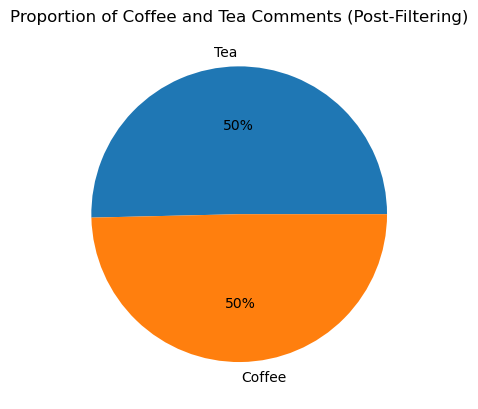

In [10]:
# plot out the proportion of comments from both filtered datasets
data = [df_tea_filtered.shape[0], df_coffee_filtered.shape[0]]
key = ["Tea", "Coffee"]

plt.pie(data, labels = key, autopct='%.0f%%')
plt.title("Proportion of Coffee and Tea Comments (Post-Filtering)")
plt.show

Summary of Observations: 
* Post-filtering, we have a balanced number of comments from the "tea" and "coffee" subreddits:
    * No. of comments (df_coffee_filtered): 4,700
    * No. of comments (df_tea_filtered): 4,770

Approach: Next Steps
* No additional filtering is needed as sample sizes naturally balance out

* *Additional Comment*: It turns out that after specifying retention of the top 4 and bottom 4 comments per thread, we have naturally balanced comment counts - without having to utilise a balancing procedure involving random selection of a subset of comments from the larger comment group to match the size of the smaller one (as was considered). This natural balance occurs because:
    * There are threads with less than 8 comments - with these threads being retained "as-is" 
    * (i.e., no elimination of comments within such threads, to ensure the filtered comments are from the entire range of threads in our data)


---

### Part 3. Save Cleaned-Filtered Dataframes as CSV Files 

In [11]:
df_coffee_filtered.to_csv("data/coffee_comments_clean_merged_filtered.csv", index=False)
df_tea_filtered.to_csv("data/tea_comments_clean_merged_filtered.csv", index=False)